[View in Colaboratory](https://colab.research.google.com/github/MauraSwift/CISC489/blob/master/Predicting_uz.ipynb)

#### Copyright 2017 Google LLC.

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Improving Neural Net Performance

## Setup

First, we'll load the data.

In [1]:
from google.colab import files
src = list(files.upload().values())[0]

Saving moc_data.npy to moc_data (2).npy


In [0]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

moc_data = np.load("moc_data.npy")
np.savetxt('moc_data.csv', moc_data, fmt='%.2f', delimiter=',', header="t,x,y,z,vx,vy,vz,m,lx,ly,lz,lvx,lvy,lvz,lm,obj,u,ux,uy,uz,H")
moc_dataframe = pd.read_csv('moc_data.csv')
moc_dataframe = moc_dataframe.reindex(
    np.random.permutation(moc_dataframe.index))

In [0]:
def preprocess_features(moc_dataframe):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = moc_dataframe[["x","y","z","vx","vy","vz","m"]]
  processed_features = selected_features.copy()
  return processed_features

def preprocess_targets(moc_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  output_targets["uz"] = moc_dataframe["uz"]
  return output_targets

In [4]:
display.display(moc_dataframe.describe())
print(moc_dataframe.keys())

,# t,x,y,z,vx,vy,vz,m,lx,ly,...,lvx,lvy,lvz,lm,obj,u,ux,uy,uz,H
count,308579.0,308579.0,308579.0,308579.0,308579.0,308579.0,308579.0,308579.0,308579.0,308579.0,...,308579.0,308579.0,308579.0,308579.0,308579.0,308579.0,308579.0,308579.0,308579.0,308579.0
mean,102.5,84719974887.5,-9662143069.8,-811286177.9,6020.8,9405.2,53.7,874.2,-2.2,3.0,...,0.4,-6.2,0.3,2.0,0.9,0.5,-0.0,0.4,-0.0,0.0
std,78.2,118326493367.7,128093571658.9,5986561724.7,16868.9,17379.3,977.0,73.7,6.8,6.2,...,8.9,8.6,7.8,1.3,0.8,0.5,0.6,0.5,0.5,0.0
min,0.0,-248124075210.1,-206371694485.1,-32284451415.3,-25691.5,-35681.3,-5925.4,554.1,-44.7,-31.4,...,-53.4,-113.5,-90.8,-0.0,0.0,0.0,-1.0,-1.0,-1.0,0.0
25%,39.2,1104806047.2,-126336521732.4,-3885942394.9,-8798.6,-1121.6,-435.1,827.0,-7.8,-2.1,...,-7.4,-12.7,-4.9,1.2,0.3,0.0,-0.5,0.1,-0.4,0.0
50%,85.0,131446647643.9,-34887468062.8,-1131341358.1,7715.6,16891.1,71.1,873.4,-3.8,3.0,...,1.0,-8.5,0.3,1.9,0.7,1.0,-0.1,0.6,-0.0,0.0
75%,152.3,184683474640.9,96202776877.1,2194240928.3,21753.0,23418.8,619.3,920.2,2.1,7.7,...,7.9,-1.7,5.8,2.7,1.3,1.0,0.5,0.8,0.3,-0.0
max,398.8,225993801929.5,250511115205.7,28777442742.6,43452.6,39398.2,8105.5,1145.8,54.7,60.5,...,83.5,37.1,99.1,41.7,5.6,1.0,1.0,1.0,1.0,0.0


Index(['# t', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'm', 'lx', 'ly', 'lz', 'lvx',
       'lvy', 'lvz', 'lm', 'obj', 'u', 'ux', 'uy', 'uz', 'H'],
      dtype='object')


In [5]:
# Choose the first 20000 examples for training.
training_examples = preprocess_features(moc_dataframe.head(20000))
training_targets = preprocess_targets(moc_dataframe.head(20000))

# Choose the last 10000 examples for validation.
validation_examples = preprocess_features(moc_dataframe.tail(10000))
validation_targets = preprocess_targets(moc_dataframe.tail(10000))

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,x,y,z,vx,vy,vz,m
count,20000.0,20000.0,20000.0,20000.0,20000.0,20000.0,20000.0
mean,84892379734.8,-8861359848.5,-840982159.8,5879.7,9420.7,52.2,873.9
std,118382304479.1,128323571253.1,5953349794.6,16852.7,17395.7,963.6,74.0
min,-247155775639.0,-205006196884.2,-32281591125.5,-23861.7,-35179.7,-5391.4,557.0
25%,-1560364435.4,-126118325302.9,-3932839874.8,-8834.2,-1345.1,-430.0,827.0
50%,131937406531.8,-33134374454.0,-1128493361.0,7384.2,16929.7,78.5,873.2
75%,185297061296.9,96318033146.8,2219919322.9,21592.2,23469.4,619.6,920.4
max,220719028645.2,249356157636.6,28030525676.9,43184.1,39124.3,7901.4,1145.8


Validation examples summary:


,x,y,z,vx,vy,vz,m
count,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0
mean,85042624296.4,-10664322676.1,-828766535.5,6102.7,9433.7,34.9,874.4
std,119431049223.3,126541559379.4,5966255530.2,16666.1,17531.7,967.2,72.6
min,-247113904306.3,-205192436951.3,-32282751214.0,-23880.4,-35180.2,-5391.2,585.3
25%,-873493970.6,-125393440410.1,-3810660656.4,-8383.5,-1292.0,-455.6,828.2
50%,132828144582.9,-35547174267.5,-1193438411.2,7783.5,17159.7,56.0,873.3
75%,185120027404.3,92030420861.3,2139750170.8,21553.6,23469.8,605.6,918.4
max,211826639973.8,249356157511.5,25595905391.3,43401.3,38305.7,7433.0,1122.2


Training targets summary:


,uz
count,20000.0
mean,-0.0
std,0.5
min,-1.0
25%,-0.4
50%,-0.0
75%,0.3
max,1.0


Validation targets summary:


,uz
count,10000.0
mean,-0.0
std,0.5
min,-1.0
25%,-0.4
50%,-0.0
75%,0.3
max,1.0


## Train the Neural Network

Next, we'll train the neural network.

In [0]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a neural network model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [0]:
def train_nn_regression_model(
    my_optimizer,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a neural network regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    my_optimizer: An instance of `tf.train.Optimizer`, the optimizer to use.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    hidden_units: A `list` of int values, specifying the number of neurons in each layer.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A tuple `(estimator, training_losses, validation_losses)`:
      estimator: the trained `DNNRegressor` object.
      training_losses: a `list` containing the training loss values taken during training.
      validation_losses: a `list` containing the validation loss values taken during training.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a DNNRegressor object.
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  dnn_regressor = tf.estimator.DNNRegressor(
      feature_columns=construct_feature_columns(training_examples),
      hidden_units=hidden_units,
      optimizer=my_optimizer
  )
  
  #targets = training_target
  #output_targets["u"] = moc_dataframe["u"] 
 
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples,  
                                          training_targets["uz"],
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["uz"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["uz"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    dnn_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.3f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  print("Final RMSE (on training data):   %0.3f" % training_root_mean_squared_error)
  print("Final RMSE (on validation data): %0.3f" % validation_root_mean_squared_error)

  return dnn_regressor, training_rmse, validation_rmse

## Linear Scaling
It can be a good standard practice to normalize the inputs to fall within the range -1, 1. This helps SGD not get stuck taking steps that are too large in one dimension, or too small in another. Fans of numerical optimization may note that there's a connection to the idea of using a preconditioner here.

In [0]:
def linear_scale(series):
  min_val = series.min()
  max_val = series.max()
  scale = (max_val - min_val) / 2.0
  return series.apply(lambda x:((x - min_val) / scale) - 1.0)

Training model...
RMSE (on training data):
  period 00 : 0.317
  period 01 : 0.306
  period 02 : 0.297
  period 03 : 0.295
  period 04 : 0.287
  period 05 : 0.285
  period 06 : 0.281
  period 07 : 0.272
  period 08 : 0.277
  period 09 : 0.275
Model training finished.
Final RMSE (on training data):   0.275
Final RMSE (on validation data): 0.280


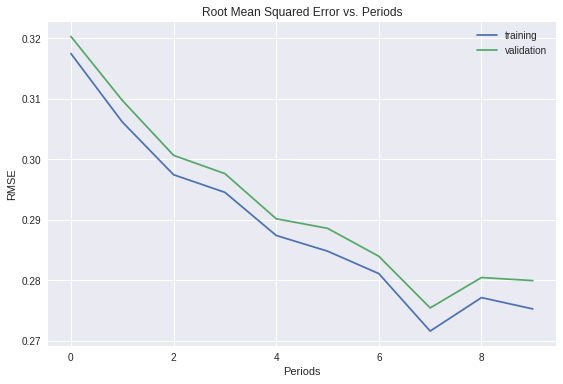

In [10]:
def normalize_linear_scale(examples_dataframe):
  """Returns a version of the input `DataFrame` that has all its features normalized linearly."""
  processed_features = pd.DataFrame()
  processed_features["x"] = linear_scale(examples_dataframe["x"])
  processed_features["y"] = linear_scale(examples_dataframe["y"])
  processed_features["z"] = linear_scale(examples_dataframe["z"])
  processed_features["vx"] = linear_scale(examples_dataframe["vx"])
  processed_features["vy"] = linear_scale(examples_dataframe["vy"])
  processed_features["vz"] = linear_scale(examples_dataframe["vz"])
  processed_features["m"] = linear_scale(examples_dataframe["m"])
  return processed_features

normalized_dataframe = normalize_linear_scale(preprocess_features(moc_dataframe))
normalized_training_examples = normalized_dataframe.head(20000)
normalized_validation_examples = normalized_dataframe.tail(10000)

_, gradient_training_losses, gradient_validation_losses = train_nn_regression_model(
    my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.005),
    steps=5000,
    batch_size=70,
    hidden_units=[15, 15],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

## Task 2: Try a Different Optimizer

** Use the Adagrad and Adam optimizers and compare performance.**

The Adagrad optimizer is one alternative. The key insight of Adagrad is that it modifies the learning rate adaptively for each coefficient in a model, monotonically lowering the effective learning rate.  This works great for convex problems, but isn't always ideal for the non-convex problem Neural Net training.  You can use Adagrad by specifying `AdagradOptimizer` instead of `GradientDescentOptimizer`.  Note that you may need to use a larger learning rate with Adagrad.

For non-convex optimization problems, Adam is sometimes more efficient than Adagrad.  To use Adam, invoke the `tf.train.AdamOptimizer` method. This method takes several optional hyperparameters as arguments, but our solution only specifies one of these (`learning_rate`). In a production setting, you should specify and tune the optional hyperparameters carefully.

First, let's try Adagrad.

Training model...
RMSE (on training data):
  period 00 : 0.411
  period 01 : 0.357
  period 02 : 0.339
  period 03 : 0.336
  period 04 : 0.311
  period 05 : 0.302
  period 06 : 0.305
  period 07 : 0.304
  period 08 : 0.296
  period 09 : 0.292
Model training finished.
Final RMSE (on training data):   0.292
Final RMSE (on validation data): 0.293


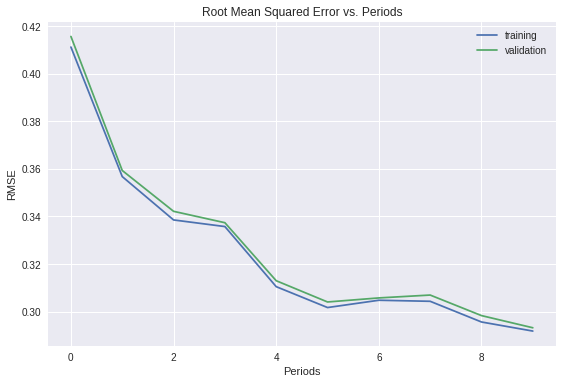

In [11]:
_, adagrad_training_losses, adagrad_validation_losses = train_nn_regression_model(
    my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.5),
    steps=500,
    batch_size=100,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

Now let's try Adam.

Training model...
RMSE (on training data):
  period 00 : 0.379
  period 01 : 0.333
  period 02 : 0.320
  period 03 : 0.307
  period 04 : 0.309
  period 05 : 0.293
  period 06 : 0.289
  period 07 : 0.278
  period 08 : 0.278
  period 09 : 0.274
Model training finished.
Final RMSE (on training data):   0.274
Final RMSE (on validation data): 0.278


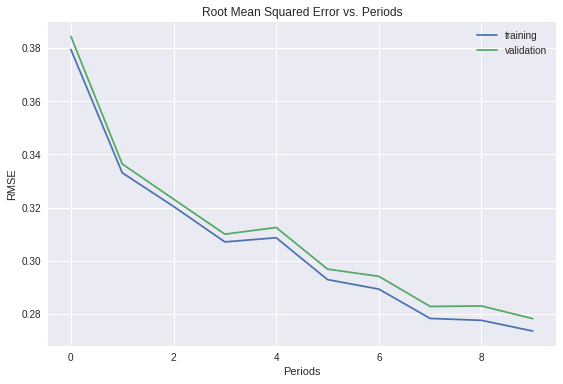

In [12]:
_, adam_training_losses, adam_validation_losses = train_nn_regression_model(
    my_optimizer=tf.train.AdamOptimizer(learning_rate=0.009),
    steps=500,
    batch_size=100,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

Let's print a graph of loss metrics side by side.

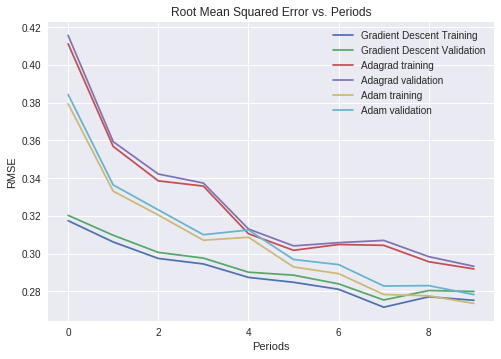

In [13]:
plt.ylabel("RMSE")
plt.xlabel("Periods")
plt.title("Root Mean Squared Error vs. Periods")
plt.plot(gradient_training_losses, label='Gradient Descent Training')
plt.plot(gradient_validation_losses, label='Gradient Descent Validation')
plt.plot(adagrad_training_losses, label='Adagrad training')
plt.plot(adagrad_validation_losses, label='Adagrad validation')
plt.plot(adam_training_losses, label='Adam training')
plt.plot(adam_validation_losses, label='Adam validation')
_ = plt.legend()